スマホでの測位、補正あり


In [1]:
import sys

sys.path.append("../")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from positioning.readwav import readwav
from positioning.get_spectrum_amplitude import get_spectrum_amplitude
from positioning.sound_db import MicRevisionDB
from positioning import tools

In [3]:
db = MicRevisionDB("../data/reference_2d", "../data/phone-angle", interval=0.2)

In [4]:
true_pos = pd.read_csv("../data/phone-pos_20230911/true_positions.csv", index_col=0)

In [5]:
est_poses = []
est_polars = []
errors = []
for i in range(20):
    test_signal = readwav(f"../data/phone-pos_20230911/test{i}.wav")
    err = []
    pos = []
    polar = []
    for j in range(100):
        est_polar = np.ravel(
            db.positioning(test_signal[j * 96000 : (j + 2) * 96000], output="polar")
        )
        est_pos = tools.polar_to_rect(est_polar[1], np.radians(est_polar[0]))
        pos.append(est_pos)
        polar.append(est_polar)
        err.append(np.linalg.norm(est_pos - true_pos.iloc[i]))
    est_poses.append(pos)
    est_polars.append(polar)
    errors.append(err)

In [6]:
df_est = pd.DataFrame()
for i in range(20):
    df_est_pos = pd.DataFrame(est_poses[i], columns=["x", "y"])
    df_est_pos["azimuth"] = np.array(est_polars[i])[:, 0]
    df_est_pos["distance"] = np.array(est_polars[i])[:, 1]
    df_est_pos["mic_angle"] = np.array(est_polars[i])[:, 2]
    df_est_pos["error"] = errors[i]
    df_est_pos["test_position"] = f"test{i}"
    df_est = pd.concat([df_est, df_est_pos])
df_est.reset_index(inplace=True, drop=True)

In [7]:
df_est.head()

,x,y,azimuth,distance,mic_angle,error,test_position
0,-0.267829,0.397072,-34.0,0.478956,82.0,0.602722,test0
1,-0.266429,0.394997,-34.0,0.476452,82.0,0.605226,test0
2,-0.265795,0.394058,-34.0,0.475320,82.0,0.606358,test0
3,-0.265334,0.393374,-34.0,0.474495,82.0,0.607183,test0
4,-0.267069,0.395946,-34.0,0.477597,81.0,0.604081,test0


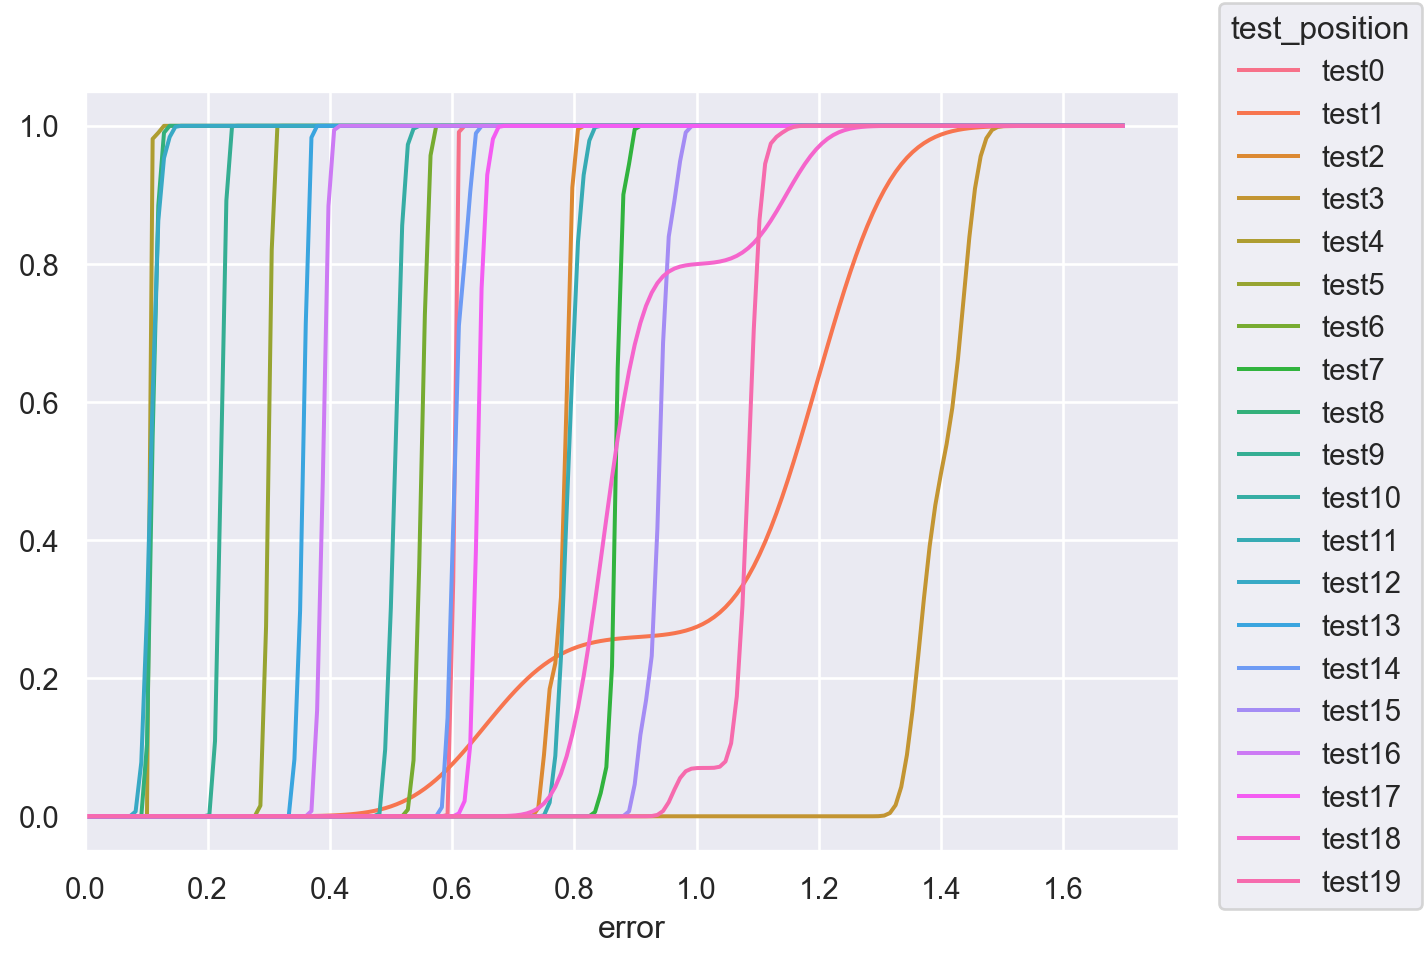

In [8]:
(
    so.Plot(df_est, x="error", color="test_position")
    .add(so.Lines(), so.KDE(cumulative=True, common_norm=False))
    .limit(x=(0, None))
)

In [38]:
sns.set()

(0.0, 1.5302281432837688)

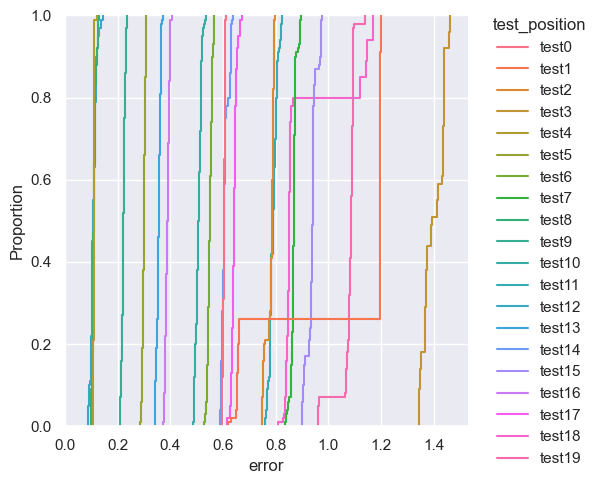

In [39]:
sns.displot(df_est, x="error", hue="test_position", kind="ecdf")
plt.xlim(0, None)

In [9]:
df_positions = df_est[["x", "y", "test_position"]]
df_positions.loc[:, "true_or_test"] = "test"
true_pos["test_position"] = true_pos.index
true_pos["true_or_test"] = "true"
df_positions = pd.concat([df_positions, true_pos])
df_positions.reset_index(drop=True, inplace=True)
df_positions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              2020 non-null   float64
 1   y              2020 non-null   float64
 2   test_position  2020 non-null   object 
 3   true_or_test   2020 non-null   object 
dtypes: float64(2), object(2)
memory usage: 63.3+ KB


/var/folders/y1/_8gjlcgj5vd54qpx7m_q4hlw0000gn/T/ipykernel_34225/2238469347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positions.loc[:, "true_or_test"] = "test"


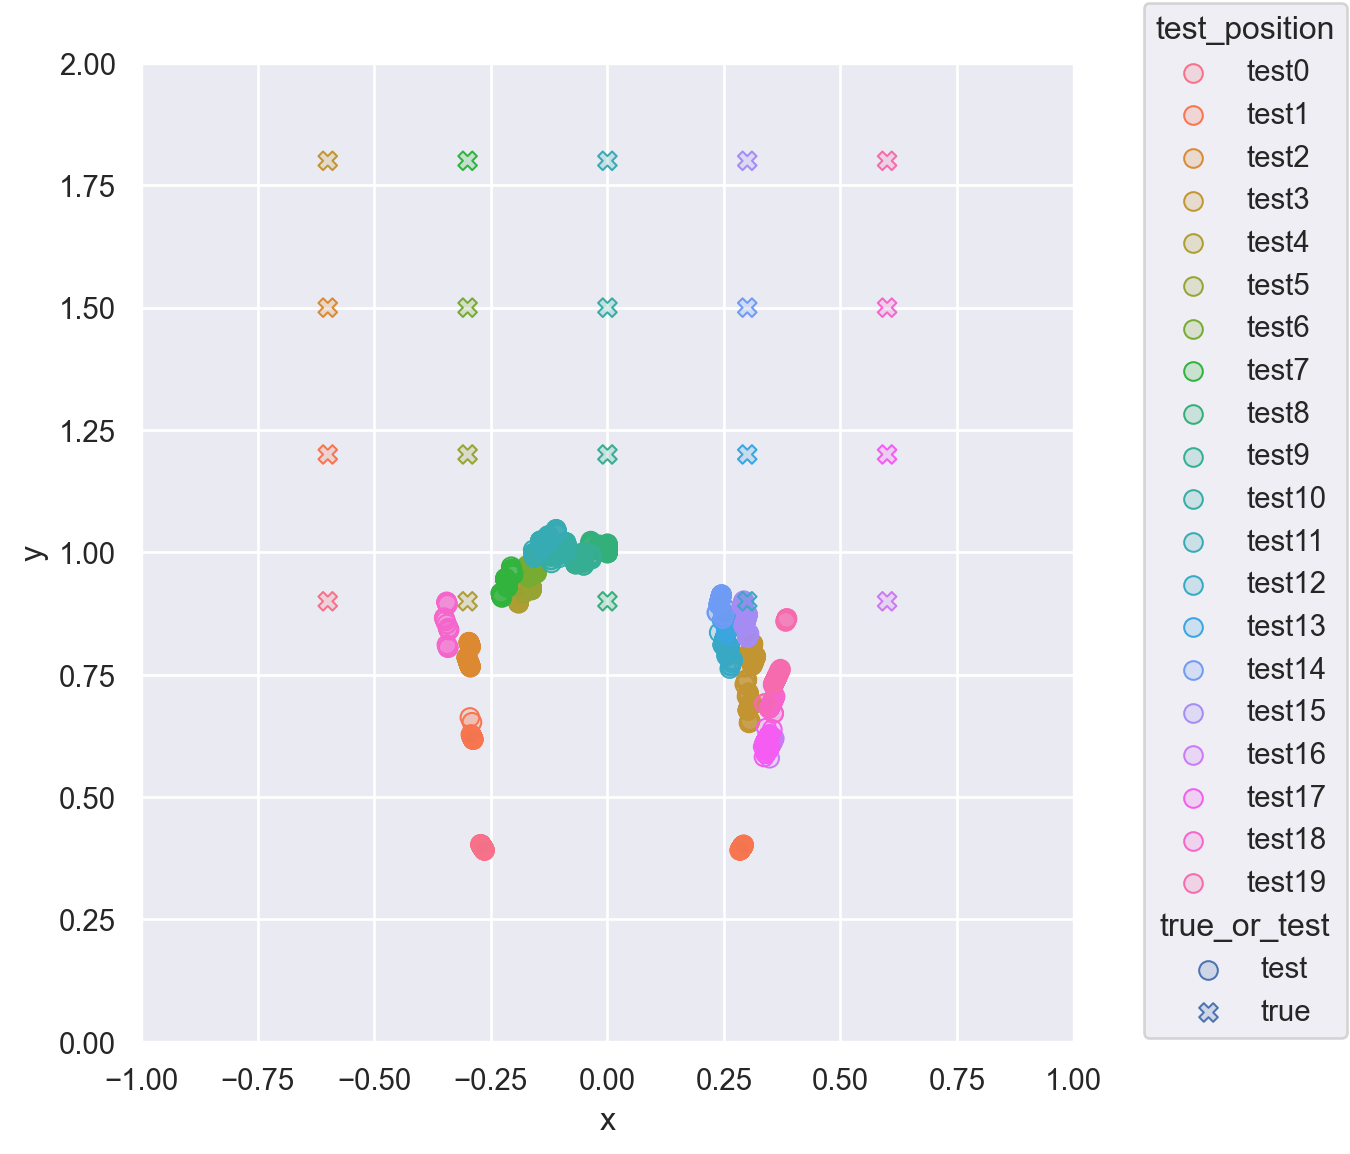

In [10]:
(
    so.Plot(df_positions, x="x", y="y", color="test_position", marker="true_or_test")
    .add(so.Dots(pointsize=7))
    .limit(x=(-1, 1), y=(0, 2))
    .layout(size=(6, 6))
)

In [11]:
true_distance, true_azimuth = tools.rect_to_polar(true_pos["x"], true_pos["y"])
true_pos["distance"] = true_distance
true_pos["azimuth"] = true_azimuth
true_pos["mic_angle"] = np.abs(true_pos["azimuth"])
true_pos.head()

,x,y,test_position,true_or_test,distance,azimuth,mic_angle
test0,-0.6,0.9,test0,true,1.081665,-33.690068,33.690068
test1,-0.6,1.2,test1,true,1.341641,-26.565051,26.565051
test2,-0.6,1.5,test2,true,1.615549,-21.801409,21.801409
test3,-0.6,1.8,test3,true,1.897367,-18.434949,18.434949
test4,-0.3,0.9,test4,true,0.948683,-18.434949,18.434949


In [12]:
df_polar = df_est[["distance", "azimuth", "mic_angle", "test_position"]]
df_polar.loc[:, "true_or_test"] = "test"
df_polar = pd.concat(
    [
        df_polar,
        true_pos[["distance", "azimuth", "mic_angle", "test_position", "true_or_test"]],
    ]
)
df_polar.reset_index(drop=True, inplace=True)
df_polar.head()

/var/folders/y1/_8gjlcgj5vd54qpx7m_q4hlw0000gn/T/ipykernel_34225/571681891.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_polar.loc[:, "true_or_test"] = "test"


,distance,azimuth,mic_angle,test_position,true_or_test
0,0.478956,-34.0,82.0,test0,test
1,0.476452,-34.0,82.0,test0,test
2,0.475320,-34.0,82.0,test0,test
3,0.474495,-34.0,82.0,test0,test
4,0.477597,-34.0,81.0,test0,test


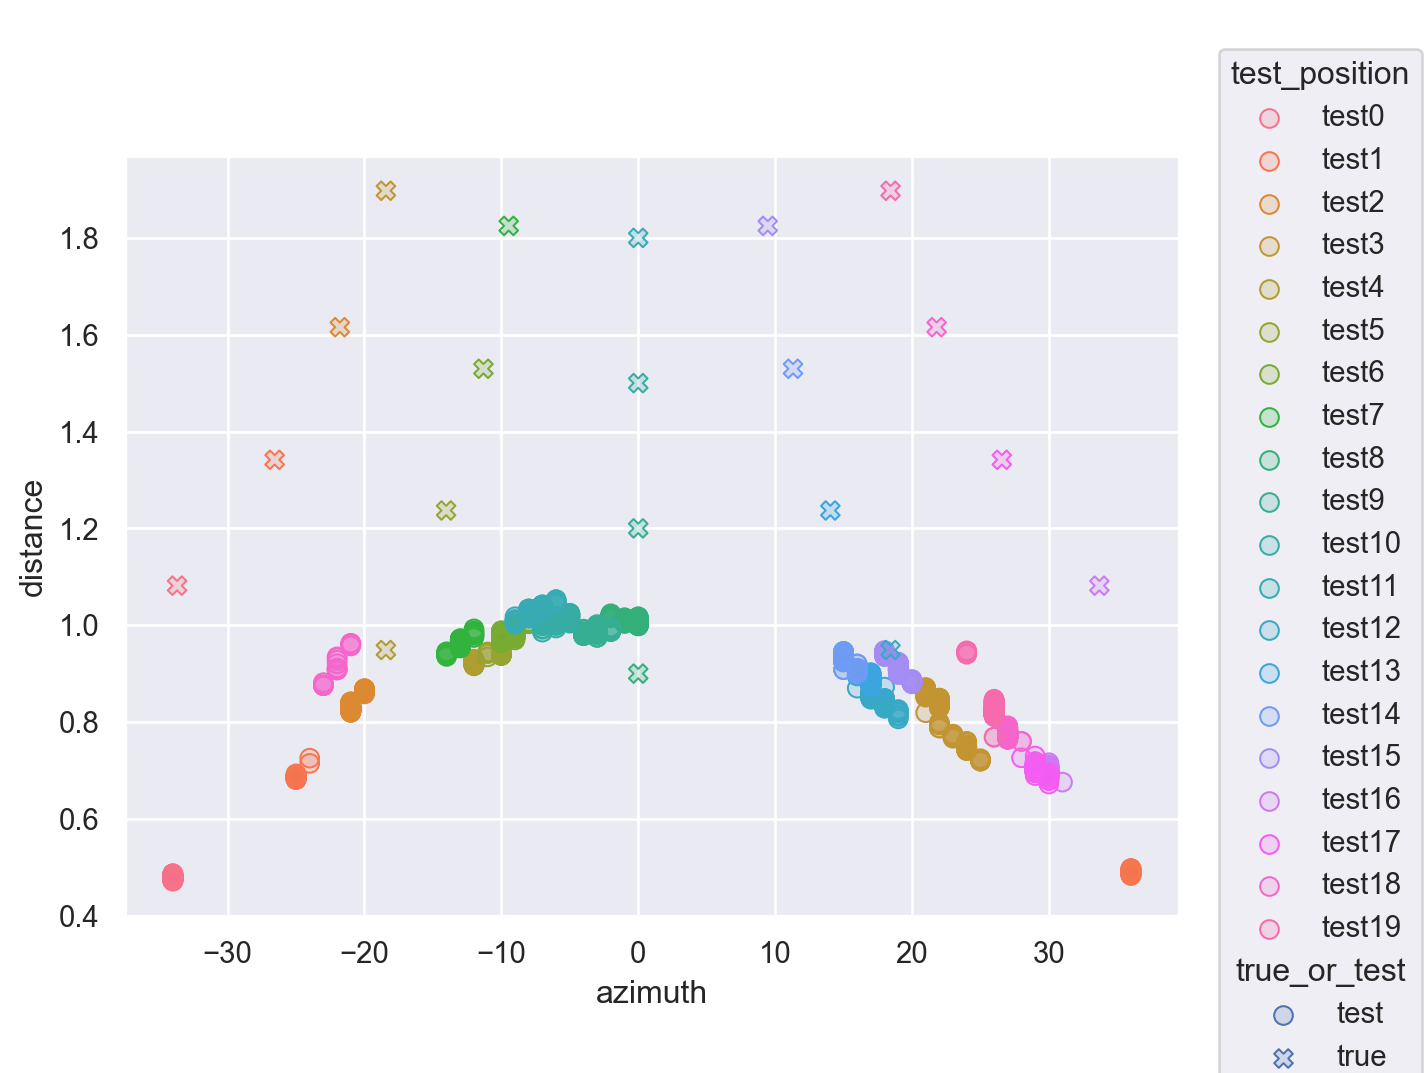

In [13]:
(
    so.Plot(
        df_polar,
        x="azimuth",
        y="distance",
        color="test_position",
        marker="true_or_test",
    ).add(so.Dots(pointsize=7))
)

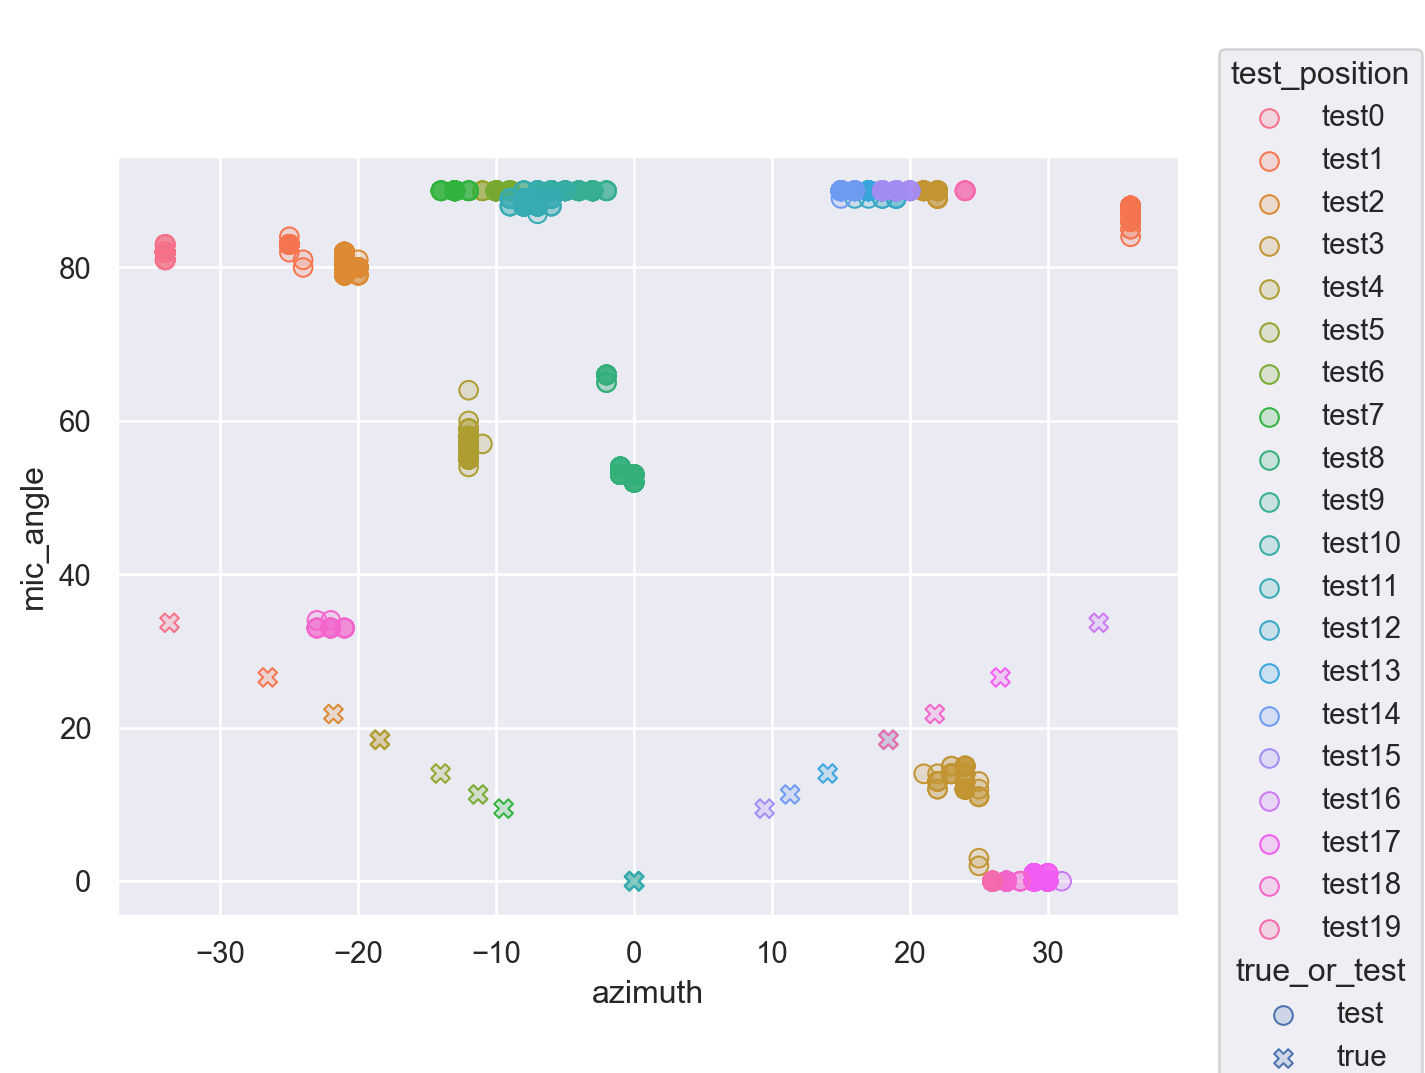

In [14]:
(
    so.Plot(
        df_polar,
        x="azimuth",
        y="mic_angle",
        color="test_position",
        marker="true_or_test",
    ).add(so.Dots(pointsize=7))
)

In [15]:
fiftyth_p = []
ninetyth_p = []
test_points = df_est["test_position"].unique()
for p in test_points:
    fiftyth_p.append(np.percentile(df_est[df_est["test_position"] == p]["error"], 50))
    ninetyth_p.append(np.percentile(df_est[df_est["test_position"] == p]["error"], 90))
df_cdf = pd.DataFrame(
    {"test_position": test_points, "50th": fiftyth_p, "90th": ninetyth_p}
)
df_cdf.head(20)

,test_position,50th,90th
0,test0,0.603646,0.607964
1,test1,1.197406,1.198060
2,test2,0.786746,0.792893
3,test3,1.394752,1.439851
4,test4,0.108311,0.108980
5,test5,0.299509,0.306405
6,test6,0.549881,0.559227
7,test7,0.868291,0.875257
8,test8,0.109124,0.120611
9,test9,0.221749,0.231967


In [16]:
true_pos.rename(columns={"azimuth": "true_azimuth"}, inplace=True)

In [17]:
df_polar = pd.merge(
    df_polar, true_pos[["test_position", "true_azimuth"]], on="test_position"
)
df_polar["azimuth_error"] = np.abs(df_polar["azimuth"] - df_polar["true_azimuth"])

In [18]:
df_polar.head()

,distance,azimuth,mic_angle,test_position,true_or_test,true_azimuth,azimuth_error
0,0.478956,-34.0,82.0,test0,test,-33.690068,0.309932
1,0.476452,-34.0,82.0,test0,test,-33.690068,0.309932
2,0.475320,-34.0,82.0,test0,test,-33.690068,0.309932
3,0.474495,-34.0,82.0,test0,test,-33.690068,0.309932
4,0.477597,-34.0,81.0,test0,test,-33.690068,0.309932


In [20]:
df_polar["azimuth_error"] = np.abs(df_polar["azimuth_error"])

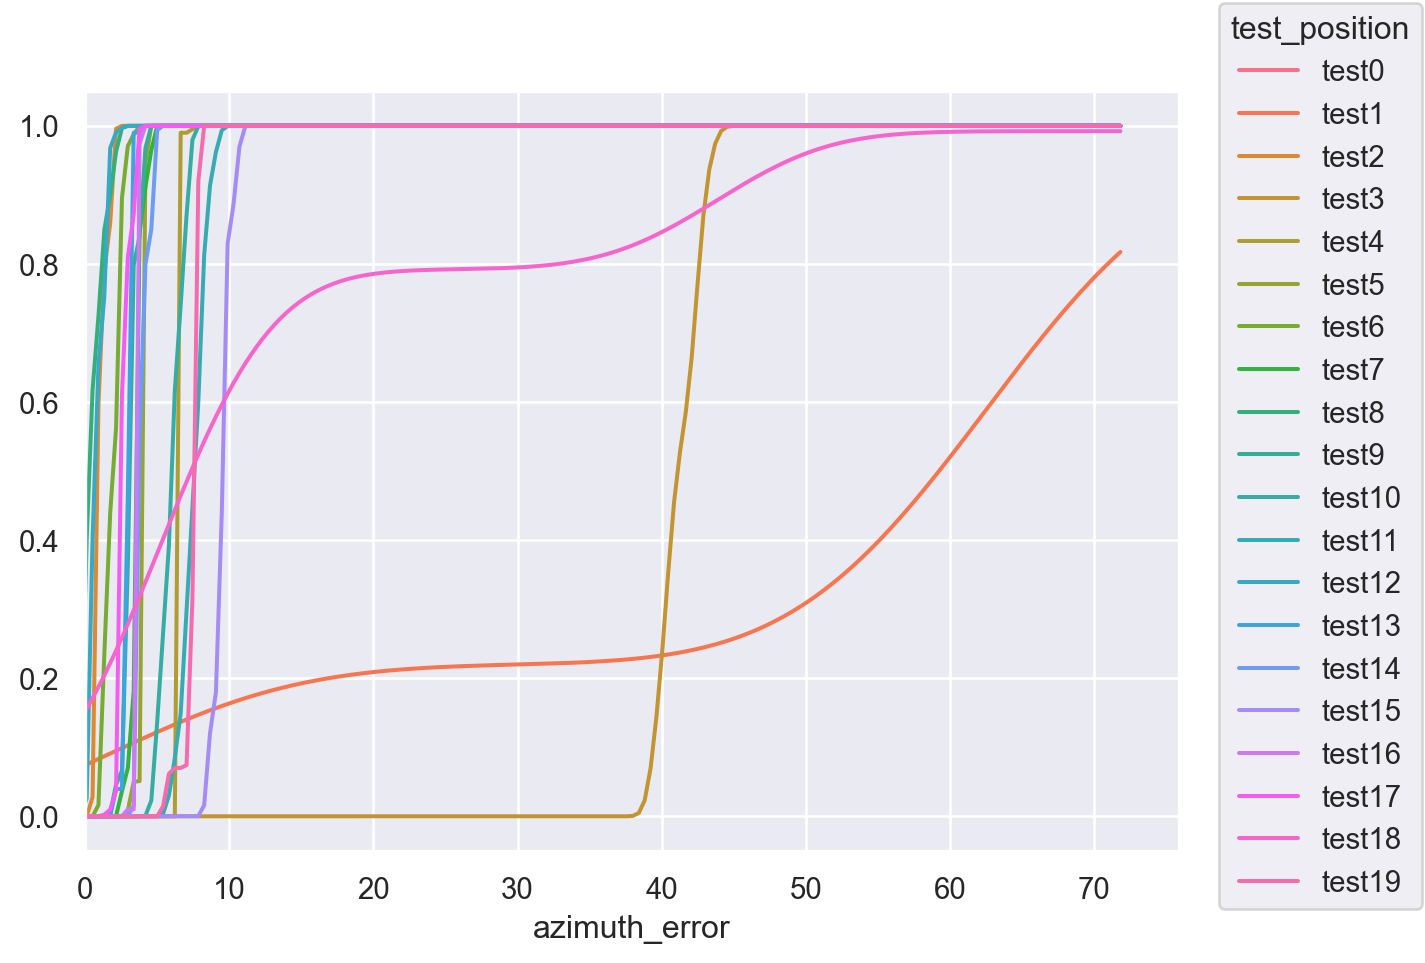

In [33]:
(
    so.Plot(
        df_polar[df_polar["true_or_test"] == "test"],
        x="azimuth_error",
        color="test_position",
    )
    .add(so.Line(), so.KDE(cumulative=True, common_norm=False))
    .limit(x=(0, None))
)

In [22]:
df_polar["azimuth_error"].describe()

count    2020.000000
mean        8.220605
std        14.094963
min         0.000000
25%         2.309932
50%         3.690068
75%         6.576212
max        62.565051
Name: azimuth_error, dtype: float64

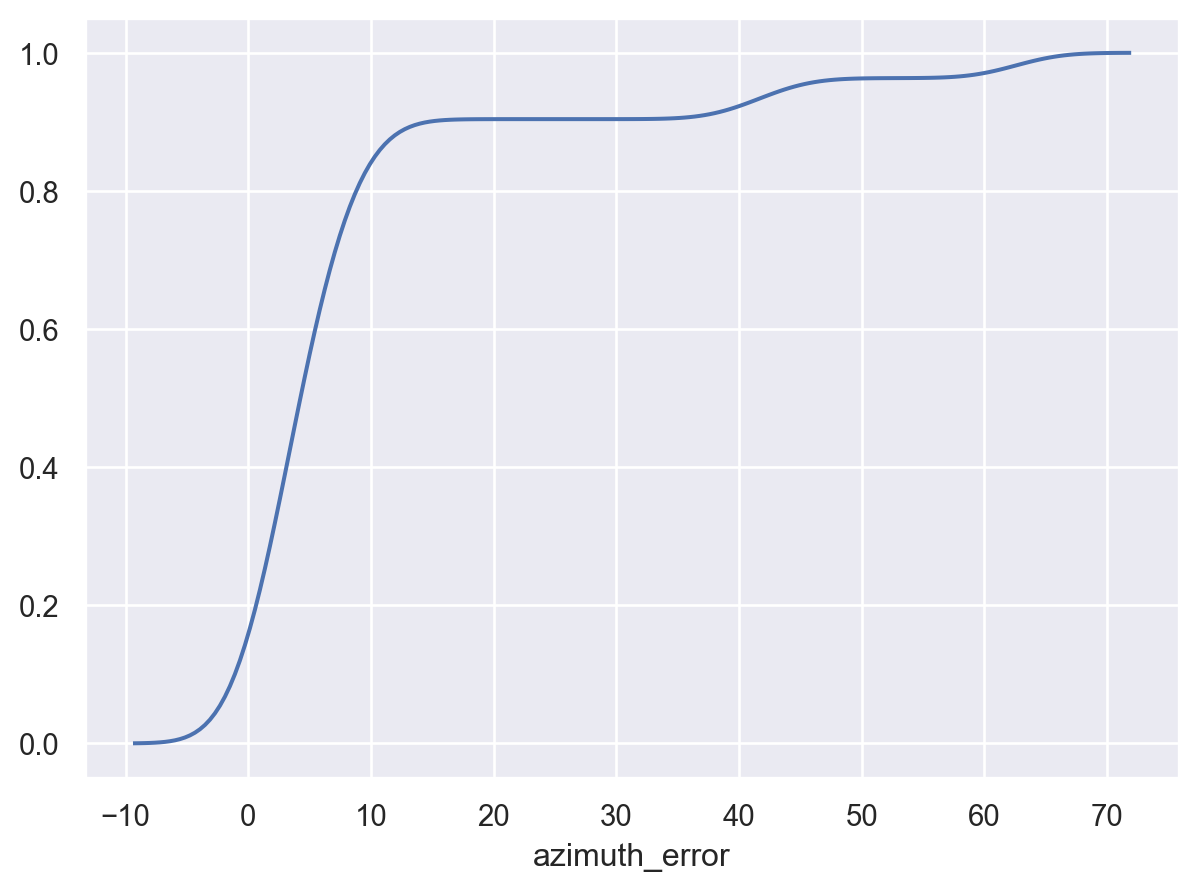

In [25]:
(
    so.Plot(df_polar, x="azimuth_error").add(
        so.Lines(), so.KDE(cumulative=True, common_norm=False)
    )
)

In [28]:
print(df_polar[df_polar["test_position"] == "test1"])

     distance    azimuth  mic_angle test_position true_or_test  true_azimuth  \
101  0.491439  36.000000  86.000000         test1         test    -26.565051   
102  0.488211  36.000000  88.000000         test1         test    -26.565051   
103  0.497397  36.000000  86.000000         test1         test    -26.565051   
104  0.485475  36.000000  88.000000         test1         test    -26.565051   
105  0.491377  36.000000  87.000000         test1         test    -26.565051   
..        ...        ...        ...           ...          ...           ...   
197  0.487427  36.000000  87.000000         test1         test    -26.565051   
198  0.487575  36.000000  87.000000         test1         test    -26.565051   
199  0.494138  36.000000  87.000000         test1         test    -26.565051   
200  0.492697  36.000000  87.000000         test1         test    -26.565051   
201  1.341641 -26.565051  26.565051         test1         true    -26.565051   

     azimuth_error  
101      62.565051

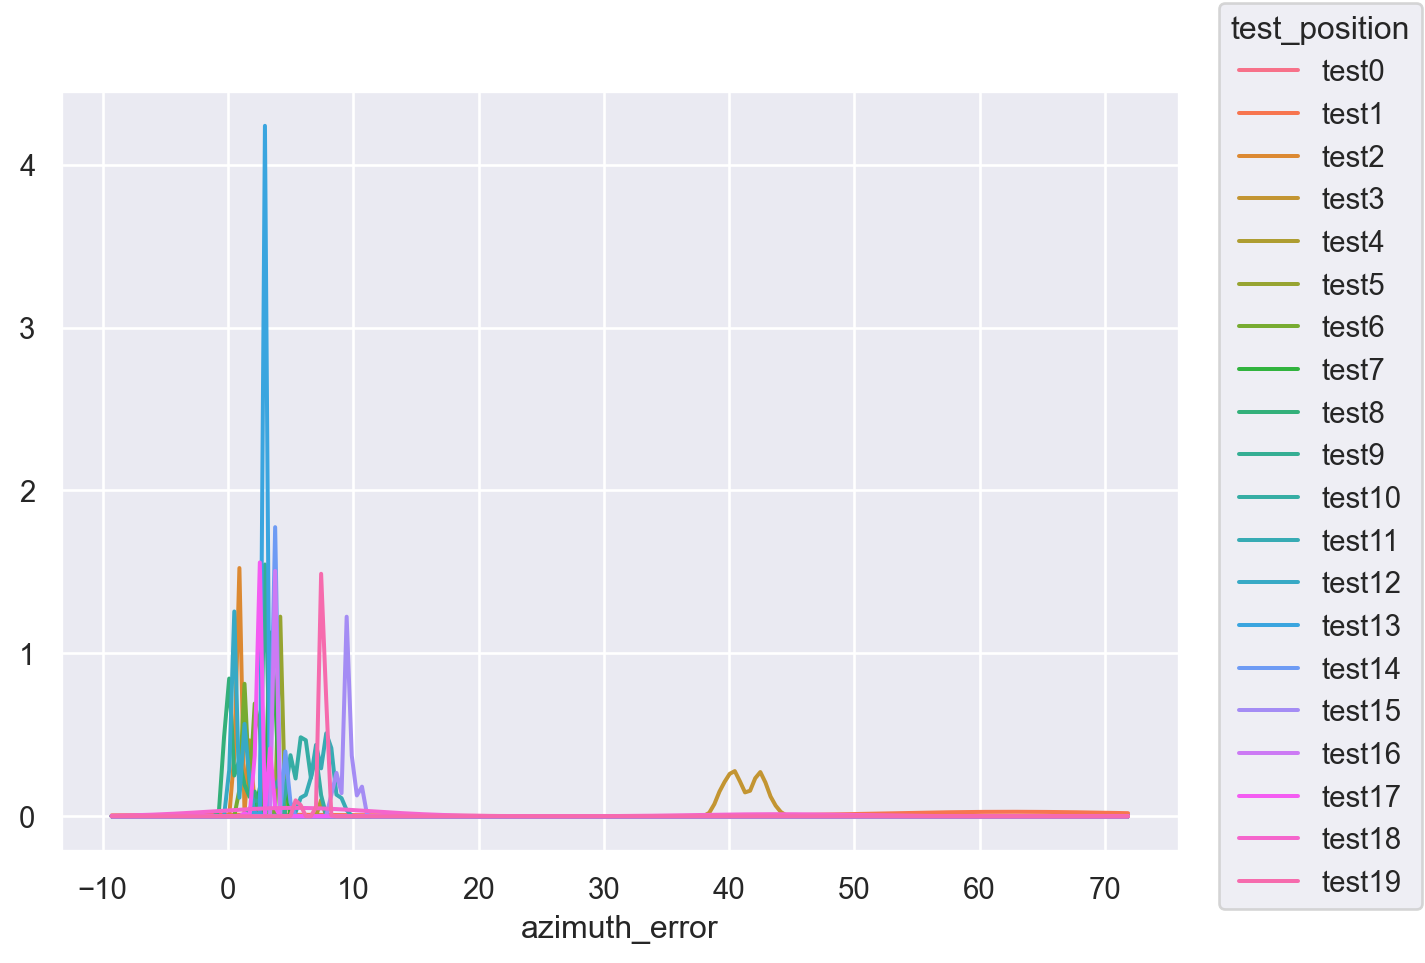

In [34]:
(
    so.Plot(
        df_polar[df_polar["true_or_test"] == "test"],
        x="azimuth_error",
        color="test_position",
    ).add(so.Line(), so.KDE(common_norm=False))
)

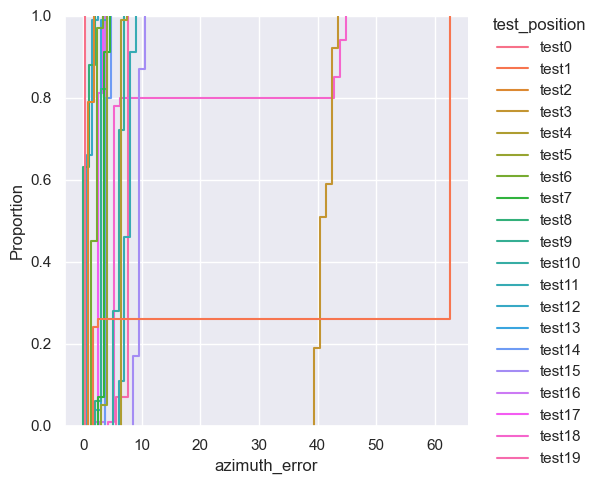

In [40]:
sns.displot(
    df_polar[df_polar["true_or_test"] == "test"],
    x="azimuth_error",
    hue="test_position",
    kind="ecdf",
)